Used This notebook to create the graph dataset as my gtx 1080 might been too outdated to use CUGRAPH to speeed up the graph based dataset transformations

In [ ]:
!pip install torch-geometric==2.7.0
%env NX_CUGRAPH_AUTOCONFIG=True
%env NETWORKX_BACKEND_PRIORITY=cugraph

env: NX_CUGRAPH_AUTOCONFIG=True
env: NETWORKX_BACKEND_PRIORITY=cugraph


In [ ]:
from gnn_utils.datasets import PositiveIterationGraph
from gnn_utils.utils import (
    graph_info, get_item_user_node_id_inv_map, generate_node_labels, top_degree_subgraph,
    normalize_zscore, log1p_standardize, drop_zero_columns
)

from torch_geometric.transforms import Compose, AddRandomWalkPE, AddLaplacianEigenvectorPE
import networkx as nx
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import numpy as np
import torch
from functools import partial
from gnn_utils.transforms import (
    AddDegreeCentrality, AddPageRank,
    AddBipartiteClusteringCoefficient, AddBirank,
    AddClosenessCentralities, AddBetweennessCentralities,
    AddConstraintStructuralHoles, AddLaplacianEigenvectorRelativeDistance,
    AddRandomWalkRelativeDistance, AddBipartiteClosenessCentralities, AddBipartiteBetweennessCentralities,
    AddBipartiteOverlapWeighted
)

In [ ]:
nx.config

NetworkXConfig(backend_priority=BackendPriorities(algos=['cugraph'], generators=['cugraph']), backends=Config(cugraph=Config(use_compat_graphs=True)), cache_converted_graphs=True, fallback_to_nx=True, warnings_to_ignore=set())

In [ ]:
!printenv | grep NX

NX_CUGRAPH_AUTOCONFIG=True
NETWORKX_FALLBACK_TO_NX=true


In [ ]:
ROOT_DATA_DIR = "./data"
# RAW_DATA_PATH = f"{ROOT_DATA_DIR}/train-1.txt"
GRAPH_DATA_DIR = f"{ROOT_DATA_DIR}/graph_data"
RNG_SEED = 101
torch.manual_seed(RNG_SEED)
np.random.seed(RNG_SEED)

In [ ]:


dataset_transformations = Compose(
    [
        AddBetweennessCentralities(normalize=log1p_standardize, rnd_seed=RNG_SEED, betweenness_k=700), # works with smaller k used to estimate betweenesss
        AddDegreeCentrality(normalize=log1p_standardize),
        AddPageRank(normalize=log1p_standardize),
        AddConstraintStructuralHoles(normalize=log1p_standardize),

        AddLaplacianEigenvectorPE(k=32, is_undirected=True), # works with k=16 was fast and little memeory can try up 32
        # need to manually removed zero coumns
        AddRandomWalkPE(walk_length=2), # works for small numbers test: 3,
        AddLaplacianEigenvectorRelativeDistance(normalize=normalize_zscore, lpe_is_undirected=True, lpe_k=32),
        AddRandomWalkRelativeDistance(normalize=normalize_zscore, walk_length=2),

        # to long need to retest with time
        # AddBipartiteClusteringCoefficient(), # havent gotten to run it for along time
        # AddClosenessCentralities(normalize=normalize_zscore), # runs for a long time did not fully test
        # AddBipartiteClosenessCentralities(), # runs for some time need to test
        # AddBipartiteBetweennessCentralities(), # runs for a long time
        # AddBipartiteOverlapWeighted(), ran for 5 mins
    ]
)

# These need the set of nodes from "one side" of the bipartite graph
bipartite_pre_transform = [
        partial(AddBirank, normalize=normalize_zscore)
    ]

# Remember to drop RW all zero columns
# the first node feature column is just a place holder drop it
dataset = PositiveIterationGraph(
    root=GRAPH_DATA_DIR,
    # raw_dataset_txt_path=RAW_DATA_PATH,
    add_user_item_node_mapping=True,
    is_undirected=True,
    pre_transform=dataset_transformations,
    bipartite_pre_transform=bipartite_pre_transform,
    # force_reload=True,
)

torch.cuda.empty_cache()
torch.cuda.synchronize()

Processing...
/usr/local/lib/python3.12/dist-packages/torch_geometric/utils/sparse.py:276: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj = torch.sparse_csr_tensor(


[drop_zero_columns] Kept 1 / 2 columns; dropped 1.


In [27]:
# download dataset folder
# !zip -r graph_data.zip ./data/graph_data
# from google.colab import files
# files.download("graph_data.zip")

  adding: data/graph_data/ (stored 0%)
  adding: data/graph_data/processed/ (stored 0%)
  adding: data/graph_data/processed/pre_transform.pt (deflated 64%)
  adding: data/graph_data/processed/pre_filter.pt (deflated 67%)
  adding: data/graph_data/processed/data.pt (deflated 55%)
  adding: data/graph_data/raw/ (stored 0%)
  adding: data/graph_data/raw/train-1.txt (deflated 56%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
graph = dataset[0]
graph_info(graph)

Summary
----------------------------------------
Nodes: 69716
Edges: 2474518 (undirected)
Node features: 6 dims
Edge features: 33 dims
Self-loops: False
Isolated nodes: 0 / 69716
Mean degree: 35.49 | Max degree: 1848.0
Density: 0.000509
Data device: cpu
Data types: x=torch.float32, edge_index=torch.int64
Approx. tensor memory: 377.38 MB
----------------------------------------


In [26]:
# def force_memory_clear(objs_to_del: list):
#   for obj in objs_to_del:
#     del obj
#   torch.cuda.empty_cache()
#   import gc
#   gc.collect()
# force_memory_clear([])

print(graph.keys())
print()
graph.x[0]

['laplacian_eigenvector_pe', 'users_node_id_map', 'random_walk_pe', 'item_node_id_map', 'edge_attr', 'x', 'edge_index']



tensor([ 1.0000, -0.1270, -0.3180, -0.4164, -0.0380, -0.1730])

In [ ]:
graph_nx = to_networkx(graph, to_undirected=True, node_attrs=[], edge_attrs=[])
user_node_id_inv_map, item_node_id_inv_map = get_item_user_node_id_inv_map(graph)
nx_node_labels = generate_node_labels(graph_nx, user_node_id_inv_map, item_node_id_inv_map)

In [ ]:
# test_t = AddBirank(br_first_node_set=tuple(user_node_id_inv_map.keys()), normalize=normalize_zscore) works
# test_t = AddBipartiteOverlapWeighted(bp_first_node_set=tuple(user_node_id_inv_map.keys()), normalize=normalize_zscore)

# kernel crashed
# test_t = AddKatz(normalize=log1p_standardize, katz_alpha=1/float(max(nx.adjacency_spectrum(graph_nx))))
# failed to converge after 5000 iterations maybe more?
# test_t = AddKatz(normalize=log1p_standardize, katz_alpha=0.5, katz_beta=0.5)

# graph = test_t(graph)

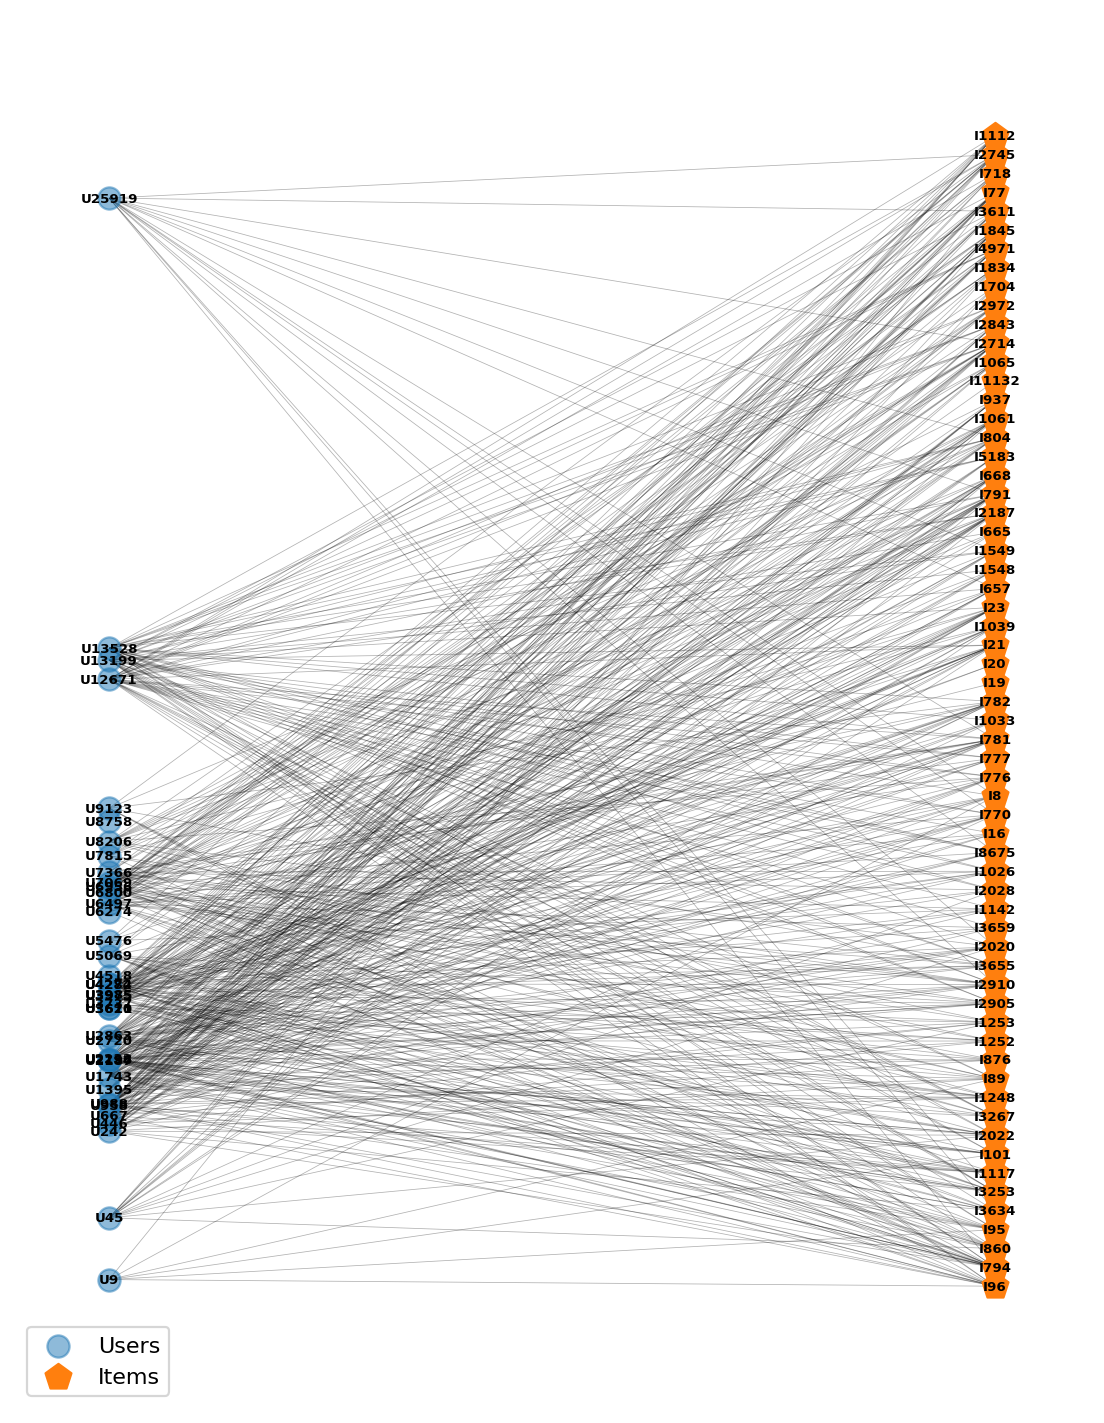

In [ ]:

# Draw a small sampled subgraph to avoid lag
plt.figure(figsize=(7, 9), dpi=160)
# H = graph_nx.subgraph(list(graph_nx.nodes())[:100])
H = top_degree_subgraph(graph_nx, top_n=100)

# pos = nx.spring_layout(H, seed=100)
pos = nx.bipartite_layout(H, set(user_node_id_inv_map.keys()))

node_centrality = nx.degree_centrality(H)
# find which nodes in H are users/items
H_users = [n for n in H if n in user_node_id_inv_map]
H_items = [n for n in H if n in item_node_id_inv_map]

# draw edges first
nx.draw_networkx_edges(H, pos, alpha=0.30, width=0.35)

# draw user nodes (blue)
nx.draw_networkx_nodes(
    H, pos,
    nodelist=H_users,
    node_color="tab:blue",
    node_shape="o",
    node_size=100,
    label="Users",
    alpha=0.5
)

# draw item nodes (orange)
nx.draw_networkx_nodes(
    H, pos,
    nodelist=H_items,
    node_color="tab:orange",
    # node_color=[node_centrality[node] for node in H_items],
    node_shape="p",
    node_size=150,
    label="Items",
    # cmap="magma"
)

nx.draw_networkx_labels(H, pos, {n: nx_node_labels.get(n, str(n)) for n in H.nodes()}, font_size=6, font_weight="bold");

plt.legend(scatterpoints=1, fontsize=10, loc="lower left")
plt.axis("off")
plt.tight_layout()
plt.show()